# Fig6

In [10]:
from zebrafish_ms2_paper.simulation import Params, simulate, sim_ms2, delay_protein
from zebrafish_ms2_paper.trace_analysis import binarize_trace, get_on_and_off_times, get_burst_durations, get_burst_inactive_durations, extract_traces
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from multiprocessing import Pool
import pandas as pd
import pickle


In [22]:
"""plot params"""
linewidth = 4
fontweight = 'bold'
fontsize = 24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
rc('axes', linewidth=4)



## Fig6B,C,D
Plot example traces for the three burst regulation models. Here we also plot the predicted protein traces, though we removed these from the final figure for simplicity. This code generates new stochastic simulations, so the traces won't be exactly the same was what is plotted in the figure.

In [18]:
"""fixed model params"""
w = 3.65
delta_t = 1.0
sigma = 0.2


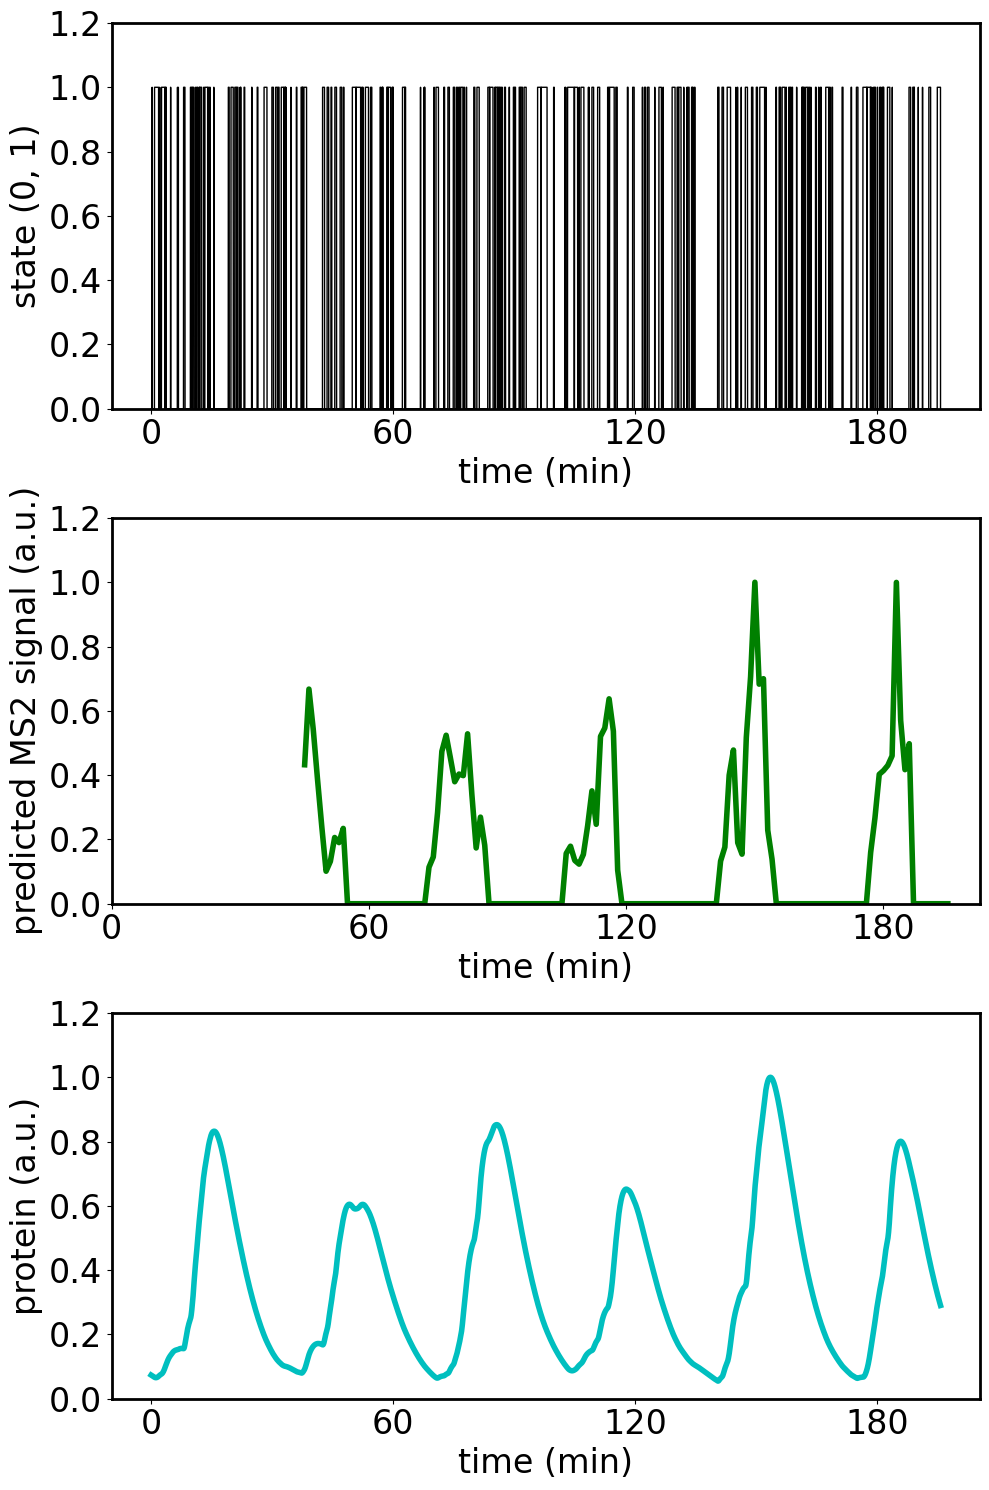

In [19]:
"""amplitude regulation"""
p = Params()
p.transcription_rate_0 = 0.0
p.transcription_rate_1 = 400.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = 240
p.dt = 0.01
p.max_time_to_next_reaction = 1.0
p.k_on0 = 2 * 0.8
p.k_off0 = 2 * 1.6
p.k_on1 = 0.0
p.k_off1 = 0.0
p.KD = 1.0
p.n = 2.0
p.delay = 8

state, mrna, protein, tvec, p = simulate(p)
burn_in_time = 45
start_id = np.where(tvec > burn_in_time)[0][0]
state = state[start_id:]
mrna = mrna[start_id:]
protein = protein[start_id:]
tvec = tvec[start_id:] - burn_in_time

p_tau = (p.transcription_rate_1 > 0) * delay_protein(protein, tvec, p.delay)
loading_rate = p.transcription_rate_1 * 1 / (1 + (p_tau / p.KD) ** p.n)

detection_threshold = 0.2 * np.max(loading_rate[np.where(tvec > 2 * p.delay)[0][0]]) * w
ms2, t_obs = sim_ms2(state, tvec, loading_rate, w, delta_t, sigma, detection_threshold)

start_id = np.where(t_obs > burn_in_time)[0][0]
ms2 = ms2[start_id:]
t_obs = t_obs[start_id:] 

# plot
# state
plt.figure(figsize=(10, 15))
plt.subplot(3,1,1)
plt.plot(tvec, state, 'k-', linewidth=1)

#plt.title('amplitude regulation', fontsize=fontsize)
plt.ylabel('state (0, 1)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

# MS2
plt.subplot(3,1,2)
plt.plot(t_obs, ms2 / np.max(ms2), 'g-', linewidth=4)

#plt.title('amplitude regulation', fontsize=fontsize)
plt.ylabel('predicted MS2 signal (a.u.)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

# protein
plt.subplot(3,1,3)
plt.plot(tvec, protein / np.max(protein), 'c-', linewidth=4)

#plt.title('amplitude regulation', fontsize=fontsize)
plt.ylabel('protein (a.u.)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()




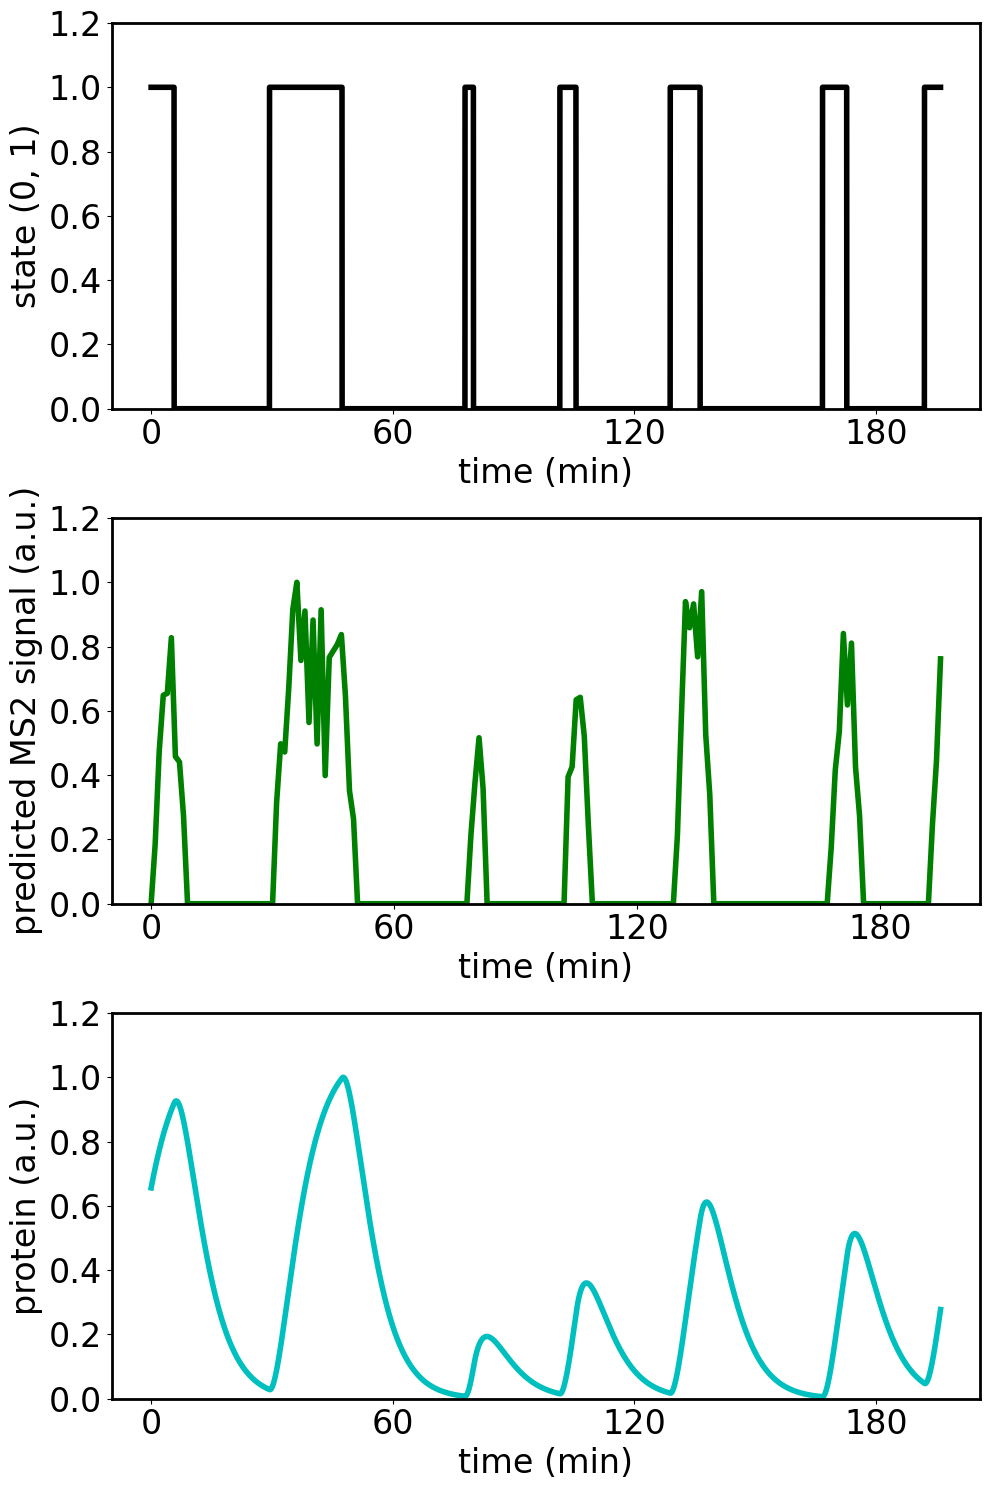

In [20]:
"""k_on regulation"""
p = Params()
p.transcription_rate_0 = 1.0
p.transcription_rate_1 = 0.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = 240
p.dt = 0.01
p.max_time_to_next_reaction = 1.0

p.KD = 1e-2
p.n = 2

p.k_on0 = 0.0
p.k_off0 = 0.08

p.k_on1 = 0.03 / p.KD ** p.n
p.k_off1 = 0.0

p.delay = 0

state, mrna, protein, tvec, p = simulate(p)
burn_in_time = 45
start_id = np.where(tvec > burn_in_time)[0][0]
state = state[start_id:]
mrna = mrna[start_id:]
protein = protein[start_id:]
tvec = tvec[start_id:] - burn_in_time

p_tau = p.transcription_rate_0 + (p.transcription_rate_1 > 0) * delay_protein(protein, tvec, p.delay)
loading_rate = p.transcription_rate_0 + p.transcription_rate_1 * 1 / (1 + (p_tau / p.KD) ** p.n)
detection_threshold = 0.2 * np.max(loading_rate[np.where(tvec > 2 * p.delay)[0][0]]) * w
ms2, t_obs = sim_ms2(state, tvec, loading_rate, w, delta_t, sigma, detection_threshold)


# plot
linewidth = 4
fontweight = 'bold'
fontsize = 24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
rc('axes', linewidth=2)

# state
plt.figure(figsize=(10, 15))
plt.subplot(3,1,1)
plt.plot(tvec, state, 'k-', linewidth=4)

#plt.title('frequency regulation', fontsize=fontsize)
plt.ylabel('state (0, 1)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

# MS2
plt.subplot(3,1,2)
plt.plot(t_obs, ms2 / np.max(ms2), 'g-', linewidth=4)

#plt.title('frequency regulation', fontsize=fontsize)
plt.ylabel('predicted MS2 signal (a.u.)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

# protein
plt.subplot(3,1,3)
plt.plot(tvec, protein / np.max(protein), 'c-', linewidth=4)

#plt.title('frequency regulation', fontsize=fontsize)
plt.ylabel('protein (a.u.)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

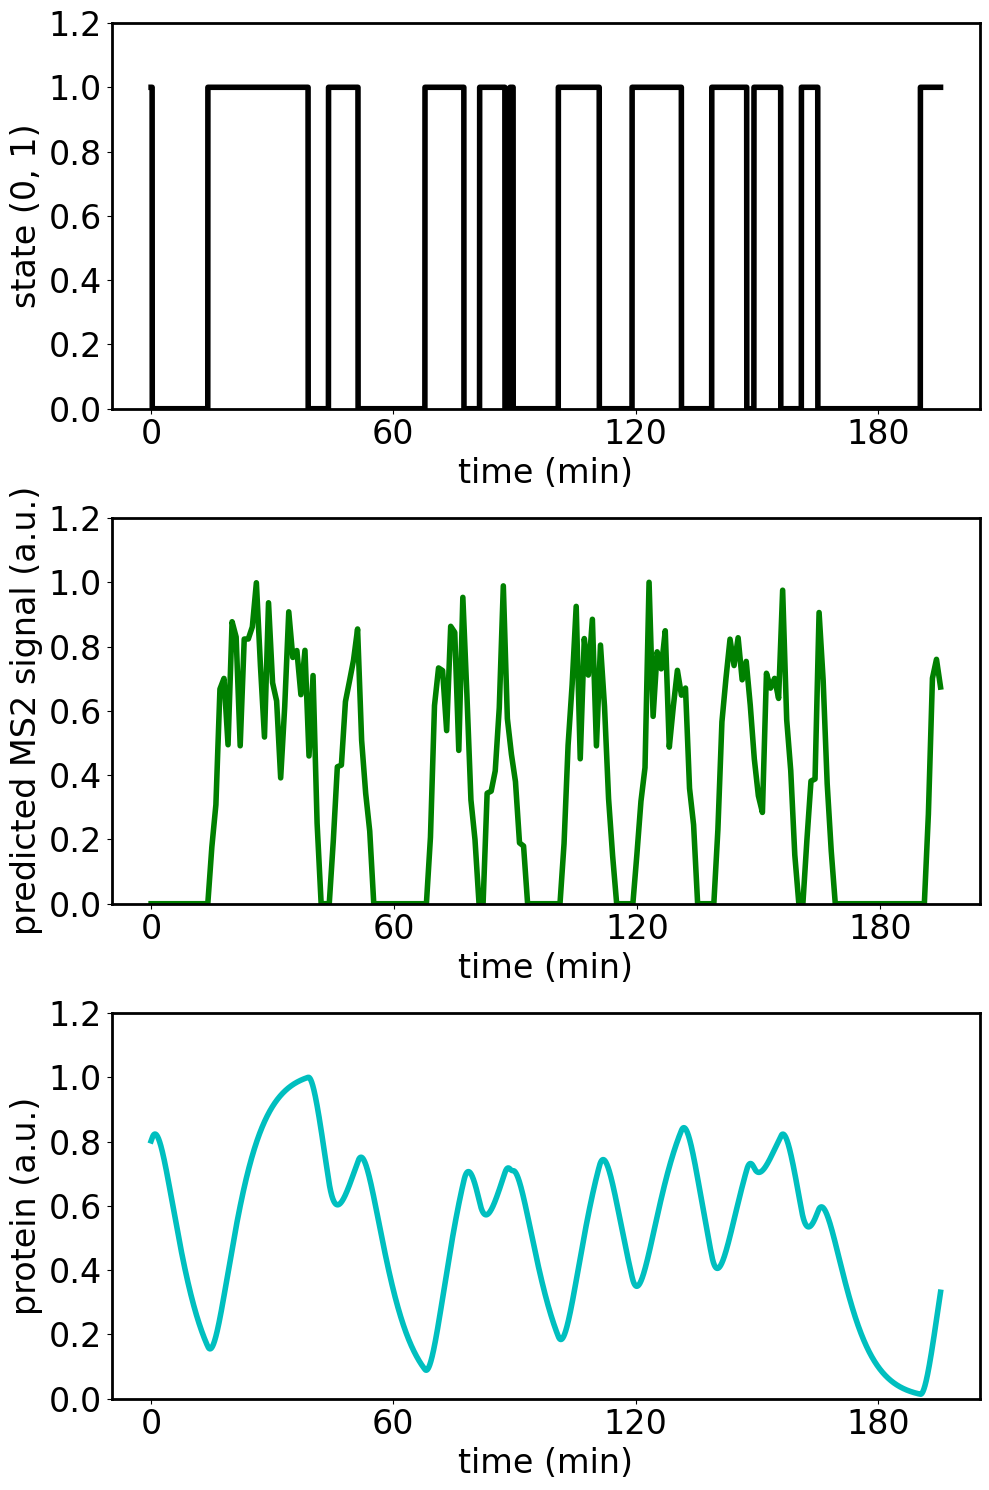

In [21]:
"""k_off regulation"""
p = Params()
p.transcription_rate_0 = 1.0
p.transcription_rate_1 = 0.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = 240
p.dt = 0.01
p.max_time_to_next_reaction = 1.0

p.k_on0 = 0.08
p.k_off0 = 0.0

p.k_on1 = 0.0
p.k_off1 = 0.2

# p.KD = 1.0
# p.n = 2.0
p.KD = 12.0
p.n = 12.0

p.delay = 0

state, mrna, protein, tvec, p = simulate(p)
burn_in_time = 45
start_id = np.where(tvec > burn_in_time)[0][0]
state = state[start_id:]
mrna = mrna[start_id:]
protein = protein[start_id:]
tvec = tvec[start_id:] - burn_in_time

p_tau = (p.transcription_rate_1 > 0) * delay_protein(protein, tvec, p.delay)
loading_rate = p.transcription_rate_0 + p.transcription_rate_1 * 1 / (1 + (p_tau / p.KD) ** p.n)

detection_threshold = 0.2 * np.max(loading_rate[np.where(tvec > 2 * p.delay)[0][0]]) * w
ms2, t_obs = sim_ms2(state, tvec, loading_rate, w, delta_t, sigma, detection_threshold)


# plot
linewidth = 4
fontweight = 'bold'
fontsize = 24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
rc('axes', linewidth=2)

# state
plt.figure(figsize=(10, 15))
plt.subplot(3,1,1)
plt.plot(tvec, state, 'k-', linewidth=4)

#plt.title('duration regulation', fontsize=fontsize)
plt.ylabel('state (0, 1)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

# MS2
plt.subplot(3,1,2)
plt.plot(t_obs, ms2 / np.max(ms2), 'g-', linewidth=4)

#plt.title('duration regulation', fontsize=fontsize)
plt.ylabel('predicted MS2 signal (a.u.)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

# protein
plt.subplot(3,1,3)
plt.plot(tvec, protein / np.max(protein), 'c-', linewidth=4)

#plt.title('duration regulation', fontsize=fontsize)
plt.ylabel('protein (a.u.)', fontsize=fontsize)
plt.xlabel('time (min)', fontsize=fontsize)
plt.ylim([0,1.2])
plt.xticks([0, 60, 120, 180])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()


## Fig6E
For the three models of burst auto-regulation and one set of parameters each, compute the predicted interval distributions. We use multiprocessing for speed, but this can be circumvented by simply calling func below with a longer Tmax. 

In [3]:
"""fixed model params"""
w = 3.65
delta_t = 1.0
sigma = 0.2
Tmax = 1_000
n_bins = 40
bins = np.linspace(0, 60, n_bins)
n_replicates = 20
y_max = 0.15


In [5]:
"""function for computing interval distributions"""
def func(p):
    state, mrna, protein, tvec, p = simulate(p)
    burn_in_time = 45
    start_id = np.where(tvec > burn_in_time)[0][0]
    state = state[start_id:]
    mrna = mrna[start_id:]
    protein = protein[start_id:]
    tvec = tvec[start_id:] - burn_in_time

    p_tau = (p.transcription_rate_1 > 0) * delay_protein(protein, tvec, p.delay)
    loading_rate = (p.transcription_rate_0 + p.transcription_rate_1) * 1 / (1 + (p_tau / p.KD) ** p.n)

    detection_threshold = 0.2 * np.max(loading_rate[np.where(tvec > 2 * p.delay)[0][0]]) * w
    ms2, t_obs = sim_ms2(state, tvec, loading_rate, w, delta_t, sigma, detection_threshold)

    start_id = np.where(t_obs > burn_in_time)[0][0]
    ms2 = ms2[start_id:]
    t_obs = t_obs[start_id:] 

    state = binarize_trace(ms2, t_obs, thresh=1.0, window_size=5)
    on_times, off_times = get_on_and_off_times(state, t_obs)
    active_durations  = get_burst_durations(on_times, off_times)
    inactive_durations = get_burst_inactive_durations(on_times, off_times)
    
    return active_durations, inactive_durations

def init_pool_processes():
    np.random.seed()
    



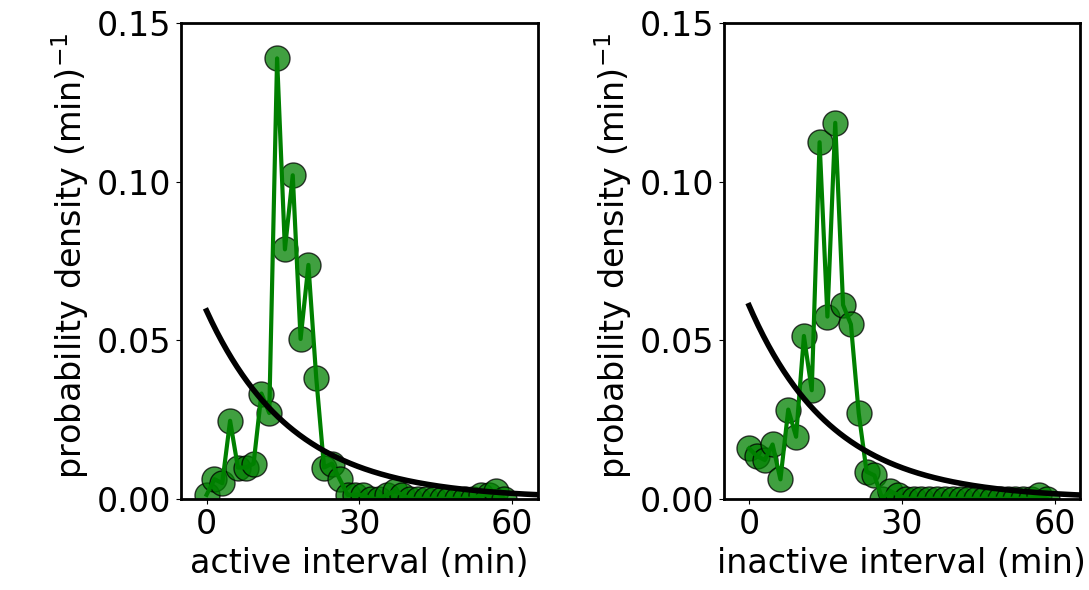

In [6]:
"""amplitude regulation"""
p = Params()
p.transcription_rate_0 = 0.0
p.transcription_rate_1 = 400.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = Tmax
p.dt = 0.01
p.max_time_to_next_reaction = 1.0
p.k_on0 = 1.6
p.k_off0 = 3.2
p.k_on1 = 0.0
p.k_off1 = 0.0
p.KD = 1.0
p.n = 2.0
p.delay = 8

p_arr = [p] * n_replicates

with Pool(processes=15, initializer=init_pool_processes) as pool:
    res = pool.map(func, p_arr)

active_durations = [item for sublist in res for item in sublist[0]]
inactive_durations = [item for sublist in res for item in sublist[1]]


plt.figure(figsize=(11, 6))
# plot active durations
plt.subplot(121)
counts, bins = np.histogram(active_durations, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.plot(bins[:-1], prob_dens, 'ko', markersize=18, markerfacecolor='g', alpha=0.75, label='data')
plt.plot(bins[:-1], prob_dens, 'g-', linewidth=3)

k = 1 / np.mean(active_durations)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='stochastic bursts')

plt.ylim([0, y_max])
plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('active interval (min)', fontsize=fontsize)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=fontsize)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
#plt.tight_layout()

plt.subplot(122)
counts, bins = np.histogram(inactive_durations, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.plot(bins[:-1], prob_dens, 'ko', markersize=18, markerfacecolor='g', alpha=0.75, label='data')
plt.plot(bins[:-1], prob_dens, 'g-', linewidth=3)

k = 1 / np.mean(inactive_durations)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='stochastic bursts')

plt.ylim([0, y_max])
plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('inactive interval (min)', fontsize=fontsize)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=fontsize)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()




In [ ]:
"""k_on regulation"""
p = Params()
p.transcription_rate_0 = 1.0
p.transcription_rate_1 = 0.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = Tmax
p.dt = 0.01
p.max_time_to_next_reaction = 1.0

p.KD = 1e-2
p.n = 2

p.k_on0 = 0.0
p.k_off0 = 0.08

p.k_on1 = 0.03 / p.KD ** p.n
p.k_off1 = 0.0

p.delay = 0

p_arr = [p] * n_replicates

with Pool(processes=15, initializer=init_pool_processes) as pool:
    res = pool.map(func, p_arr)

active_durations = [item for sublist in res for item in sublist[0]]
inactive_durations = [item for sublist in res for item in sublist[1]]


plt.figure(figsize=(11, 6))
# plot active durations
plt.subplot(121)
counts, bins = np.histogram(active_durations, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.plot(bins[:-1], prob_dens, 'ko', markersize=18, markerfacecolor='g', alpha=0.75, label='data')
plt.plot(bins[:-1], prob_dens, 'g-', linewidth=3)

k = 1 / np.mean(active_durations)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='stochastic bursts')

plt.ylim([0, y_max])
plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('active interval (min)', fontsize=fontsize)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=fontsize)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
#plt.tight_layout()

plt.subplot(122)
counts, bins = np.histogram(inactive_durations, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.plot(bins[:-1], prob_dens, 'ko', markersize=18, markerfacecolor='g', alpha=0.75, label='data')
plt.plot(bins[:-1], prob_dens, 'g-', linewidth=3)

k = 1 / np.mean(inactive_durations)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='stochastic bursts')

plt.ylim([0, y_max])
plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('inactive interval (min)', fontsize=fontsize)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=fontsize)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()





In [ ]:
"""k_off regulation"""
p = Params()
p.transcription_rate_0 = 1.0
p.transcription_rate_1 = 0.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = Tmax
p.dt = 0.01
p.max_time_to_next_reaction = 1.0

p.k_on0 = 0.08
p.k_off0 = 0.0

p.k_on1 = 0.0
p.k_off1 = 0.2

p.KD = 12.0
p.n = 12.0

p.delay = 0

p_arr = [p] * n_replicates

with Pool(processes=15, initializer=init_pool_processes) as pool:
    res = pool.map(func, p_arr)

active_durations = [item for sublist in res for item in sublist[0]]
inactive_durations = [item for sublist in res for item in sublist[1]]


plt.figure(figsize=(11, 6))
# plot active durations
plt.subplot(121)
counts, bins = np.histogram(active_durations, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.plot(bins[:-1], prob_dens, 'ko', markersize=18, markerfacecolor='g', alpha=0.75, label='data')
plt.plot(bins[:-1], prob_dens, 'g-', linewidth=3)

k = 1 / np.mean(active_durations)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='stochastic bursts')

plt.ylim([0, y_max])
plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('active interval (min)', fontsize=fontsize)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=fontsize)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
#plt.tight_layout()

plt.subplot(122)
counts, bins = np.histogram(inactive_durations, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.plot(bins[:-1], prob_dens, 'ko', markersize=18, markerfacecolor='g', alpha=0.75, label='data')
plt.plot(bins[:-1], prob_dens, 'g-', linewidth=3)

k = 1 / np.mean(inactive_durations)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='stochastic bursts')

plt.ylim([0, y_max])
plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xlabel('inactive interval (min)', fontsize=fontsize)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=fontsize)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
      
plt.tight_layout()

## Fig6F
Plot the experimental interval distributions and the null distributions from a model of unregulated bursts

In [11]:
"""load data for period and duration"""
# dorado
df = pd.read_pickle(r'/media/brandon/Data1/Somitogenesis/Dorado/gauss_001_v2_sigma_filt/filtered_df.pkl')

with open(r'/home/brandon/Downloads/non_blank_timepoints_full.pkl','rb') as fp:
    non_blank_timepoints = pickle.load(fp)




In [12]:
"""more functions for computing interval distributions. we also need func and init_pool_processes from the cell above."""
def compute_distributions(traces, bins):
    pulse_periods = []
    pulse_durations =[]
    pulse_quiets = []
    for i, trace in enumerate(traces):
        t_arr, inten_arr, nucleus = trace
        t_arr = non_blank_timepoints[t_arr.astype('int')]
        state = binarize_trace(inten_arr, t_arr, thresh=1.0, window_size=5)
        on_times, off_times = get_on_and_off_times(state, t_arr)
        if len(on_times) > 2:
            these_pulse_periods = np.diff(on_times)
            these_quiets = get_burst_inactive_durations(on_times, off_times)
            pulse_periods.extend([p for p in these_pulse_periods])
            these_pulse_durations = get_burst_durations(on_times, off_times)
            pulse_durations.extend([p for p in these_pulse_durations])
            pulse_quiets.extend([p for p in these_quiets])
            
    counts, bins = np.histogram(pulse_durations, bins=bins)
    prob_dens_durations = counts / np.sum(counts) / np.diff(bins)
    
    counts, bins = np.histogram(pulse_quiets, bins=bins)
    prob_dens_quiets = counts / np.sum(counts) / np.diff(bins)
            
    return prob_dens_durations, prob_dens_quiets


def bootstrap_distributions(traces, bins, n_bootstraps):
    duration_dist_arr = np.zeros((n_bootstraps, len(bins) - 1))
    quiet_dist_arr = np.zeros((n_bootstraps, len(bins) - 1))
    for i in range(int(n_bootstraps)):
        these_ids = np.random.randint(0, len(traces), len(traces), dtype='int')
        these_traces = [traces[j] for j in these_ids]
        
        duration_dist_arr[i], quiet_dist_arr[i] = compute_distributions(these_traces, bins)

    return duration_dist_arr, quiet_dist_arr 


def bootstrap_simulated_distributions(intervals, bins, n_bootstraps):
    interval_dist_arr = np.zeros((n_bootstraps, len(bins) - 1))
    for i in range(int(n_bootstraps)):
        these_ids = np.random.randint(0, len(intervals), len(intervals), dtype='int')
        these_intervals = [intervals[j] for j in these_ids]
        
        counts, bins = np.histogram(these_intervals, bins=bins)
        interval_dist_arr[i] = counts / np.sum(counts) / np.diff(bins)
        
    return interval_dist_arr 

In [13]:
"""extract lists of active and inactive intervals."""
traces = extract_traces(df, method='gauss3d_dog')
spots_per_trace = [np.sum(trace[1] > 0) for trace in traces]
traces = [traces[i] for i in range(len(traces)) if spots_per_trace[i] > 10]

# full dataset
pulse_periods = []
pulse_durations =[]
pulse_quiets = []
for i, trace in enumerate(traces):
    t_arr, inten_arr, nucleus = trace
    t_arr = non_blank_timepoints[t_arr.astype('int')]
    state = binarize_trace(inten_arr, t_arr, thresh=1.0, window_size=5)
    on_times, off_times = get_on_and_off_times(state, t_arr)
    if len(on_times) > 2:
        these_pulse_periods = np.diff(on_times)
        these_quiets = get_burst_inactive_durations(on_times, off_times)
        pulse_periods.extend([p for p in these_pulse_periods])
        these_pulse_durations = get_burst_durations(on_times, off_times)
        pulse_durations.extend([p for p in these_pulse_durations])
        pulse_quiets.extend([p for p in these_quiets])


        
# bootstrap 
n_bins = 30
bins = np.linspace(0, 60, n_bins)
n_bootstraps = 100
duration_dist_arr, quiet_dist_arr = bootstrap_distributions(traces, bins, n_bootstraps)
# plt.figure()
# plt.plot(bins[:-1], duration_dist_arr.T, linewidth=2)
                             
counts, bins = np.histogram(pulse_durations, bins=bins)
prob_dens_durations = counts / np.sum(counts) / np.diff(bins)

counts, bins = np.histogram(pulse_quiets, bins=bins)
prob_dens_quiets = counts / np.sum(counts) / np.diff(bins)



    



/home/brandon/Documents/Code/zebrafish-ms2-paper/zebrafish_ms2_paper/trace_analysis.py:41: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  inten_arr[i] = sub_sub_df.get(method)


In [14]:
"""simulation of unreglated bursting"""
p = Params()
p.transcription_rate_0 = 1.0
p.transcription_rate_1 = 0.0
p.translation_rate = 1.0
p.mrna_decay_rate = 0.23
p.protein_decay_rate = 0.23

p.Tmax = 1_000
p.dt = 0.01
p.max_time_to_next_reaction = 1.0
p.k_on0 = 1 / np.mean(pulse_quiets)
p.k_off0 = 1 / np.mean(pulse_durations)
p.k_on1 = 0.0
p.k_off1 = 0.0
p.KD = 1.0
p.n = 2.0
p.delay = 0

p_arr = [p] * 20

with Pool(processes=15, initializer=init_pool_processes) as pool:
    res = pool.map(func, p_arr)

active_durations = [item for sublist in res for item in sublist[0]]
inactive_durations = [item for sublist in res for item in sublist[1]]

sim_active_dist_arr = bootstrap_simulated_distributions(active_durations, bins, n_bootstraps)
sim_inactive_dist_arr = bootstrap_simulated_distributions(inactive_durations, bins, n_bootstraps)



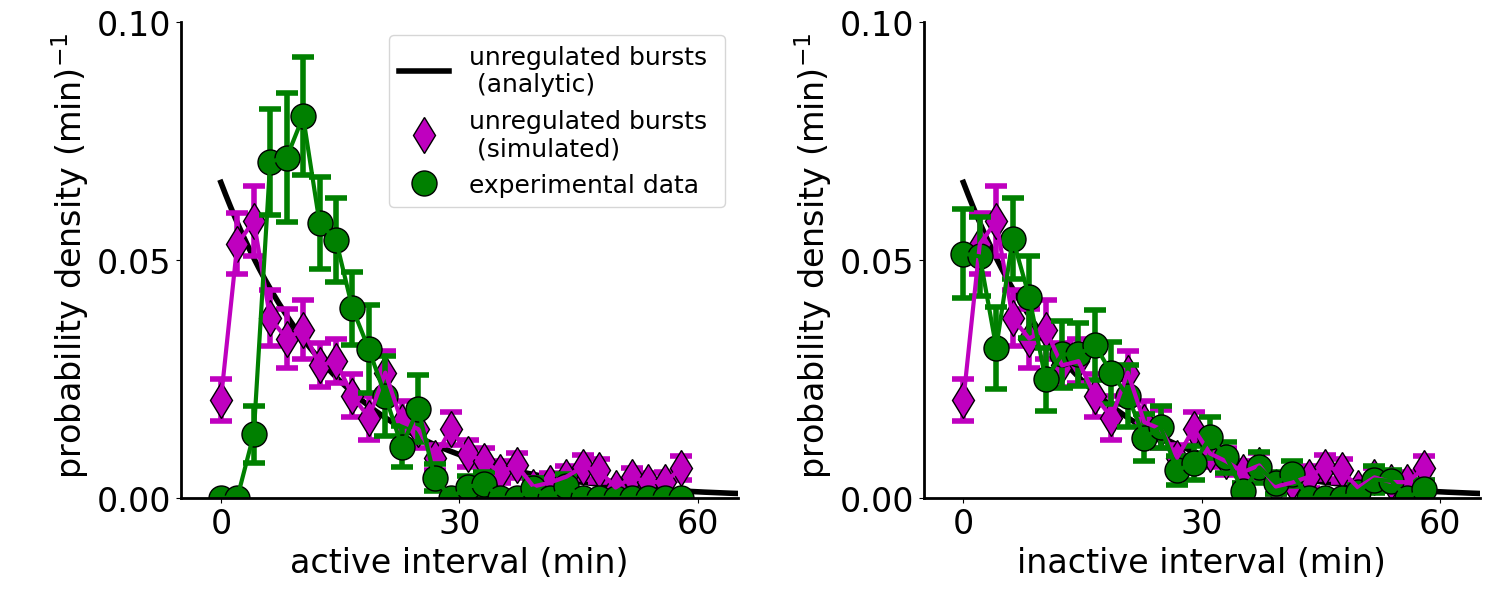

In [17]:
plt.figure(figsize=(15, 6))
ymax = 0.1

"""plot durations"""
plt.subplot(121)

# analytic
k = 1 / np.mean(pulse_quiets)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='unregulated bursts \n (analytic)')

# sim
m = np.mean(sim_inactive_dist_arr, axis=0)
s = np.std(sim_inactive_dist_arr, axis=0)
plt.errorbar(bins[:-1], m, s, color='m', linewidth=3, elinewidth=4, ecolor='m', capsize=8, capthick=4)
plt.plot(bins[:-1], m, 'kd', markersize=18, markerfacecolor='m', alpha=1, label='unregulated bursts \n (simulated)')

# data
m = np.mean(duration_dist_arr, axis=0)
s = np.std(duration_dist_arr, axis=0)
plt.errorbar(bins[:-1], m, s, color='g', linewidth=3, elinewidth=4, ecolor='g', capsize=8, capthick=4)
plt.plot(bins[:-1], m, 'ko', markersize=18, markerfacecolor='g', alpha=1, label='experimental data')

plt.xlabel('active interval (min)', fontsize=24)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=24)

plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.ylim([0, ymax])
plt.legend(fontsize=18)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['LucidaSans'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.tight_layout()


"""plot inactive durations"""
plt.subplot(122)

# analytic
k = 1 / np.mean(pulse_quiets)
x = np.linspace(0, 200, 1000)
y = k * np.exp(-k * x)
plt.plot(x, y, 'k-', linewidth=4, label='unregulated bursts \n (analytic)')

# sim
m = np.mean(sim_inactive_dist_arr, axis=0)
s = np.std(sim_inactive_dist_arr, axis=0)
plt.errorbar(bins[:-1], m, s, color='m', linewidth=3, elinewidth=4, ecolor='m', capsize=8, capthick=4)
plt.plot(bins[:-1], m, 'kd', markersize=18, markerfacecolor='m', alpha=1, label='unregulated bursts \n (simulated)')


# data
m = np.mean(quiet_dist_arr, axis=0)
s = np.std(quiet_dist_arr, axis=0)
plt.errorbar(bins[:-1], m, s, color='g', linewidth=3, elinewidth=4, ecolor='g', capsize=8, capthick=4)
plt.plot(bins[:-1], m, 'ko', markersize=18, markerfacecolor='g', alpha=1, label='experimental data')

plt.xlabel('inactive interval (min)', fontsize=24)
plt.ylabel('\n probability density (min)$^{-1}$', fontsize=24)

plt.xlim([-5, 65])
plt.xticks([0, 30, 60])
plt.yticks([0, 0.05, 0.1, 0.15])
plt.ylim([0, ymax])

#plt.legend(fontsize=18)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.tight_layout()
                         